In [1]:
import numpy as np

from numpy import fft
import lmfit
from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit
import matplotlib.pyplot as plt

from scipy.special import dawsn, erfi

import sys
sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\frxas.py')

from frxas import time_domain, models
%reload_ext autoreload
%autoreload 2

In [2]:
freq = 1
Ns = 4096 #6553600 #4096
Wfm = 100
k = 1
b = 40

t_fin = Wfm / freq
fs = Ns / (t_fin)
df = 1 / t_fin

t = np.linspace(0, t_fin-1/fs, num=Ns)
dat = 1.5 * np.cos(2*np.pi*freq*t - 46.25/180*np.pi) + .1 * np.cos(4*np.pi*freq*t - 46.25*2/180*np.pi)
unit = np.ones(dat.shape)

window = time_domain.gauss_window(unit, freq, t, b)
windat = time_domain.gauss_window(dat, freq, t, b)

freqs = np.fft.fftshift(np.fft.fftfreq(Ns,1/fs))
datfft = np.fft.fftshift(np.fft.fft(windat)/(Ns*np.pi)) 

In [3]:
class SignalModel(lmfit.model.Model):
    
    def __init__(self, *args, **kwargs):
        super(SignalModel, self).__init__(time_domain.fft_shape, *args, **kwargs)
        

In [4]:
Signal1 = SignalModel()

In [5]:
init_params = lmfit.Parameters()

# init_params.add('dt', value=t[1], vary=False)
init_params.add('freq_in', value=freq, vary=False)
init_params.add('window_param', value=b, vary=False)
init_params.add('harmonic', value=1, vary=False)
init_params.add('re_comp', value=0)
init_params.add('im_comp', value=-1)

In [6]:
result = Signal1.fit(datfft, params=init_params, frequencies=freqs )
print("Amp: ", np.sqrt(result.params['re_comp'].value**2 + result.params['im_comp'].value**2))
print("Angle: ", np.angle(result.params['re_comp'].value + 1j* result.params['im_comp'].value, deg=True))
result

Amp:  1.4999880456890446
Angle:  -46.218535312709335


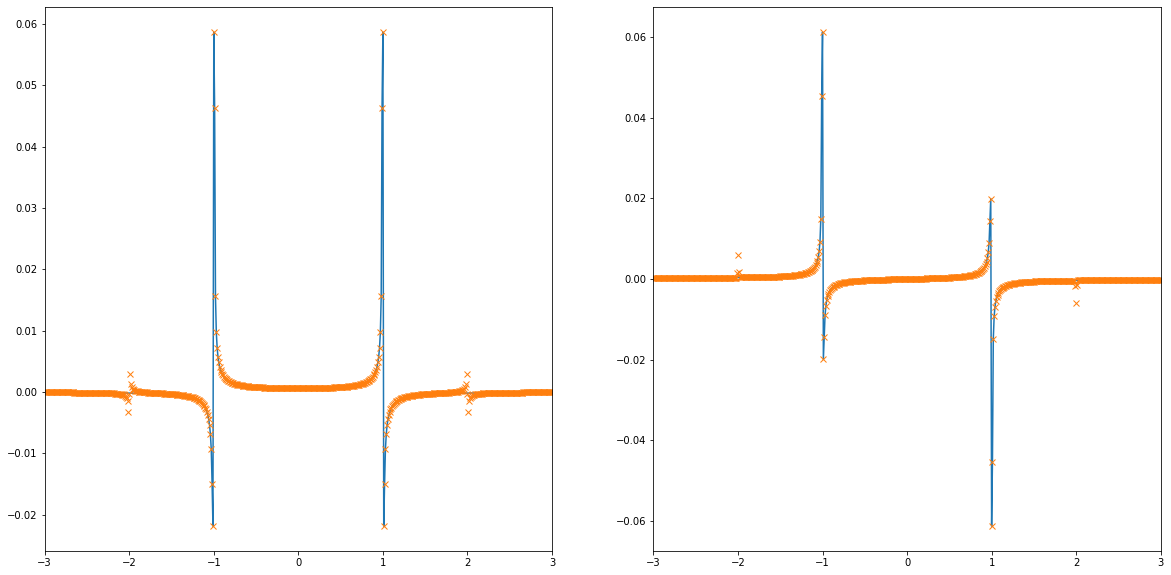

In [7]:
fit_Sig = Signal1.eval(params=result.params, frequencies=freqs)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,10))
ax1.plot(freqs, fit_Sig.real)
ax1.plot(freqs, datfft.real, 'x')

ax2.plot(freqs, fit_Sig.imag)
ax2.plot(freqs, datfft.imag, 'x')

ax1.set_xlim(-3*freq, 3*freq)
ax2.set_xlim(-3*freq, 3*freq)

plt.show()

In [8]:
dum = time_domain.fft_shape(freqs, freq, b, 1, 0, -1)

In [9]:
del dums, g_pk, g_nk, d_pk, d_nk

NameError: name 'dums' is not defined

In [10]:
k=4
vpk = [0, 0, 0, 0]
vppk = [-1, -0.1, 5.2e-2, 6.5e-3]

dums = np.zeros(freqs.shape, dtype=complex)

for i in range(1, k+1):
    g_pk = time_domain.gauss_fft(freqs, freq, b, i)
    g_nk = time_domain.gauss_fft(freqs, freq, b, -i)
    d_pk = time_domain.dawson_fft(freqs, freq, b, i)
    d_nk = time_domain.dawson_fft(freqs, freq, b, -i)

    dums += 0.5 * (vpk[i-1] * (g_pk + g_nk) + vppk[i-1] * (d_pk - d_nk)) + \
        1j / 2 * (vppk[i-1] * (g_pk - g_nk) + vpk[i-1] * (-d_pk - d_nk))

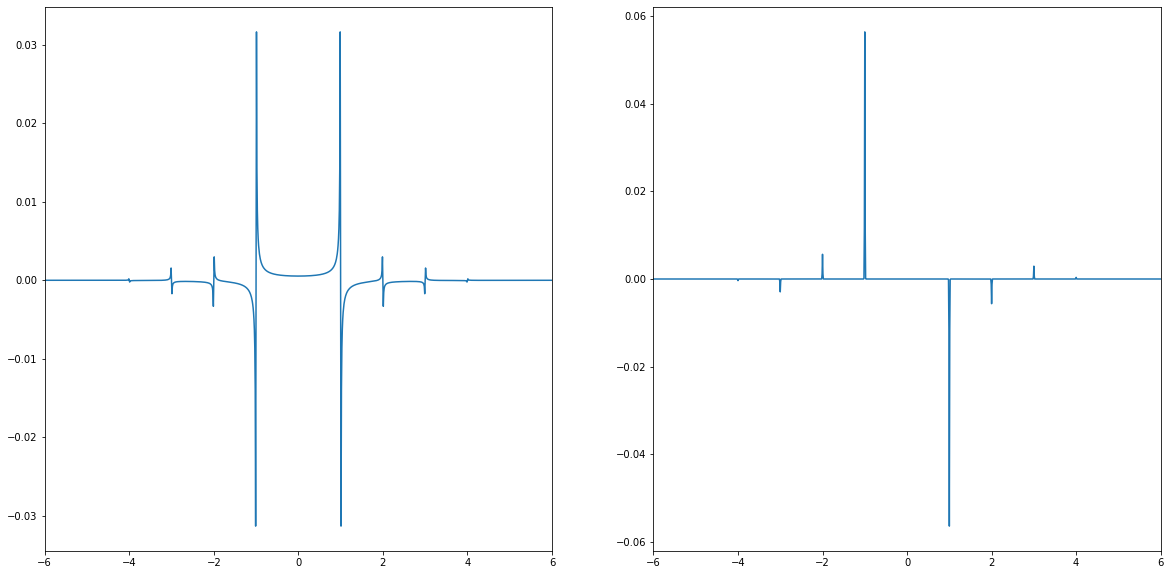

In [11]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,10))
ax1.plot(freqs, dums.real)

ax2.plot(freqs, dums.imag)

ax1.set_xlim(-6*freq, 6*freq)
ax2.set_xlim(-6*freq, 6*freq)

plt.show()

In [12]:
datfft2 = [datfft, datfft]
freqs2 = [freqs, freqs]
np.shape(datfft2)

(2, 4096)

In [13]:
params = lmfit.Parameters()

In [14]:
for iy, _ in enumerate(datfft2):
    params.add('freq_in_%i' % (iy+1), value=freq, vary=False)
    params.add('window_param_%i' % (iy+1), value=b, vary=False)
    params.add('harmonic_%i' % (iy+1), value=iy+1, vary=False)
    params.add('re_comp_%i' % (iy+1), value=0)
    params.add('im_comp_%i' % (iy+1), value=-1)

In [15]:
params

name,value,initial value,min,max,vary
freq_in_1,1.00000000,1,-inf,inf,False
window_param_1,40.0000000,40,-inf,inf,False
harmonic_1,1.00000000,1,-inf,inf,False
re_comp_1,0.00000000,0,-inf,inf,True
im_comp_1,-1.00000000,-1,-inf,inf,True
freq_in_2,1.00000000,1,-inf,inf,False
window_param_2,40.0000000,40,-inf,inf,False
harmonic_2,2.00000000,2,-inf,inf,False
re_comp_2,0.00000000,0,-inf,inf,True
im_comp_2,-1.00000000,-1,-inf,inf,True


In [16]:
mini =lmfit.Minimizer(models.objective_fun, params, fcn_args=(freqs2, datfft2, time_domain.fft_shape))

In [17]:
out = mini.minimize()
report_fit(out.params)

[[Variables]]
    freq_in_1:       1 (fixed)
    window_param_1:  40 (fixed)
    harmonic_1:      1 (fixed)
    re_comp_1:       1.03785620 +/- 0.01176317 (1.13%) (init = 0)
    im_comp_1:      -1.08296752 +/- 0.01176201 (1.09%) (init = -1)
    freq_in_2:       1 (fixed)
    window_param_2:  40 (fixed)
    harmonic_2:      2 (fixed)
    re_comp_2:      -0.00885962 +/- 0.01176313 (132.77%) (init = 0)
    im_comp_2:      -0.10865151 +/- 0.01176197 (10.83%) (init = -1)


In [18]:
def fft_adj(fft):
    dum = fft.copy()
    mag = np.abs(fft[2148])
    ang = np.angle(fft[2148])
    
    dum[2148] = 0 - 1j * mag
    dum[1948] = 0 + 1j * mag
    
    return dum

def fft_adj2(ref, fft, freq_in, freq_list, phase=-90):
    bins = time_domain.freq_bin(freq_in, freq_list, 1)
    phs = phase * np.pi/180
    
    dum = ref.copy()
    mag = np.abs(dum[bins[0, 1]])
    ang = np.angle(dum[bins[0, 1]])
    
    dum2 = fft.copy()
    mag2 = np.abs(dum2[bins[0, 1]])
    ang2 = np.angle(dum2[bins[0, 1]])
    
    angadj = phs - ang
    
    print("Before Angle1: ", ang*180/np.pi, " Angle2: ", ang2*180/np.pi)
    print("Angle adj: ", angadj*180/np.pi)
    
    dum[bins[0, 1]] = (np.cos(phs) + 1j * np.sin(phs)) * mag # 0 - 1j * mag
    dum[bins[0, 0]] = (np.cos(phs) - 1j * np.sin(phs)) * mag # 0 + 1j * mag
    
    dum2[bins[0, 1]] = (np.cos(ang2 + angadj) + 1j * np.sin(ang2 + angadj)) * mag2
    dum2[bins[0, 0]] = (np.cos(ang2 + angadj) - 1j * np.sin(ang2 + angadj)) * mag2
    print("After Angle1: ", np.angle(dum[bins[0,1]], deg=True), " Angle2: ", np.angle(dum2[bins[0,1]], deg=True))
    return dum, dum2

Mag1: 2.9999999999999996
Before Angle1:  -18.350000000000623  Angle2:  -81.86200000000106
Angle adj:  -71.64999999999937
After Angle1:  -90.0  Angle2:  -153.51200000000043
Mag1: 2.9999999999999996
Before Angle1:  -18.350000000000623  Angle2:  -18.350000000000623
Angle adj:  -71.64999999999937
After Angle1:  -90.0  Angle2:  -90.0
Before Angle1:  -18.350000000000623  Angle2:  -81.86200000000106
Angle adj:  -71.64999999999937
After Angle1:  -90.0  Angle2:  -153.51200000000043


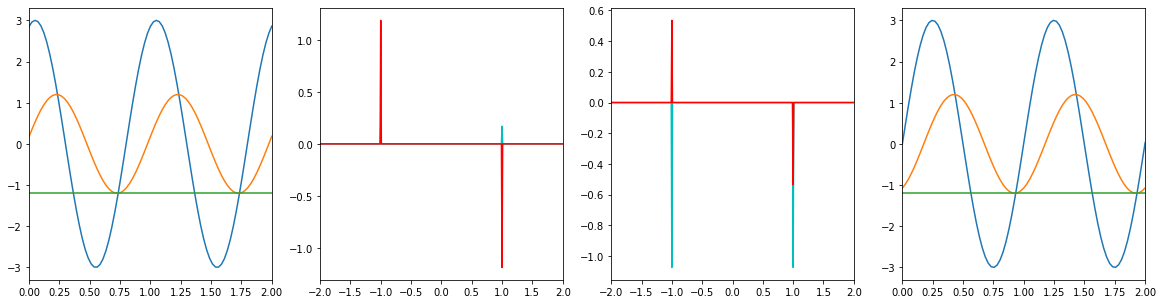

In [20]:
d1 = 3*np.cos(2*np.pi*freq*t-(18.35*np.pi/180))
d2 = 1.2*np.cos(2*np.pi*freq*t-(81.862*np.pi/180)) #+.4*np.cos(4*np.pi*freq*t-(60*np.pi/180))

freqs = fft.fftshift(fft.fftfreq(Ns,1/fs))
d1_fft = fft.fftshift(fft.fft(d1)/(Ns/2))
d2_fft = fft.fftshift(fft.fft(d2)/(Ns/2))

_, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20,5))
d2_adj = time_domain.phase_align(t, d1, d2, freq, phase=-90)
d1_adj = time_domain.phase_align(t, d1, d1, freq, phase=-90)
ax1.plot(t, d1, label='d1')
ax1.plot(t, d2, label='d2')
ax1.plot(t, np.ones(d1.shape)*np.min(d2))
ax1.set_xlim(0, 2)
# ax1.legend()

# ax2.plot(freqs, d1_fft.real, 'k', label='real d1')
# ax2.plot(freqs, d1_fft.imag, 'b', label='imag d1')
ax2.plot(freqs, d2_fft.real, 'c', label='real d2')
ax2.plot(freqs, d2_fft.imag, 'r', label='imag d2')
ax2.set_xlim(-2, 2)
# ax2.legend()

d1_fft_adj, d2_fft_adj = fft_adj2(d1_fft, d2_fft, freq, freqs, phase=-90)
# d1_fft_adj, d2_fft_adj = time_domain.phase_align(d1_fft, d2_fft, time_domain.freq_bin(freq, freqs, 1), phase=0)
# ax3.plot(freqs, d1_fft_adj.real, 'k', label='real d1')
# ax3.plot(freqs, d1_fft_adj.imag, 'b', label='imag d1')
ax3.plot(freqs, d2_fft_adj.real, 'c', label='real d2')
ax3.plot(freqs, d2_fft_adj.imag, 'r', label='imag d2')
ax3.set_xlim(-2, 2)
# ax3.legend()

# d1_adj = fft.ifft(fft.ifftshift(d1_fft_adj)*(Ns/2))
# d2_adj = fft.ifft(fft.ifftshift(d2_fft_adj)*(Ns/2))


ax4.plot(t, d1_adj.real, label='d1')
ax4.plot(t, d2_adj.real, label='d2')
ax4.plot(t, np.ones(d1.shape)*np.min(d2))
ax4.set_xlim(0, 2)
# ax4.set_ylim(-.4, .4)
# ax4.legend()

plt.show()

In [26]:
init_params

name,value,initial value,min,max,vary
freq_in,1.00000000,1,-inf,inf,False
window_param,40.0000000,40,-inf,inf,False
harmonic,1.00000000,1,-inf,inf,False
re_comp,0.00000000,0,-inf,inf,True
im_comp,-1.00000000,-1,-inf,inf,True


In [33]:
d1 = 1*np.cos(2*np.pi*freq*t-(90*np.pi/180))
d1_win = time_domain.gauss_window(d1, freq, t, b)
d1_win_fft = np.fft.fftshift(np.fft.fft(d1_win)/(Ns*np.pi))
result = Signal1.fit(d1_win_fft, params=init_params, frequencies=freqs )
print("Amp: ", np.sqrt(result.params['re_comp'].value**2 + result.params['im_comp'].value**2))
print("Angle: ", np.angle(result.params['re_comp'].value + 1j* result.params['im_comp'].value, deg=True))
result

Amp:  0.9994543059480558
Angle:  -90.0009676675508


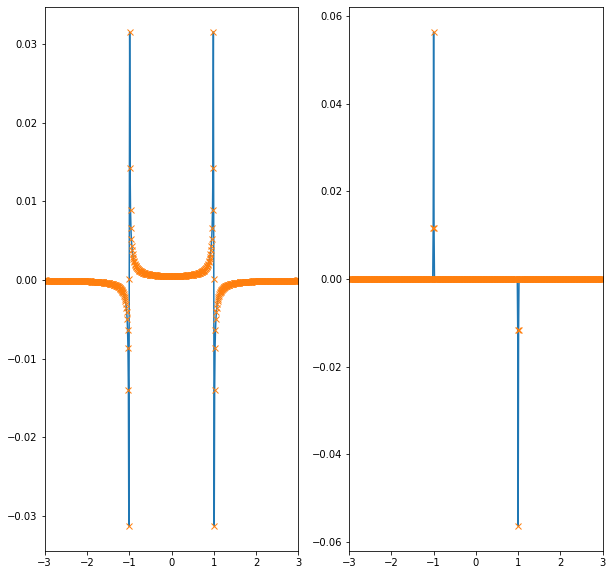

In [30]:
fit_Sig = Signal1.eval(params=result.params, frequencies=freqs)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,10))
ax1.plot(freqs, fit_Sig.real)
ax1.plot(freqs, d1_win_fft.real, 'x')

ax2.plot(freqs, fit_Sig.imag)
ax2.plot(freqs, d1_win_fft.imag, 'x')

ax1.set_xlim(-3*freq, 3*freq)
ax2.set_xlim(-3*freq, 3*freq)

plt.show()

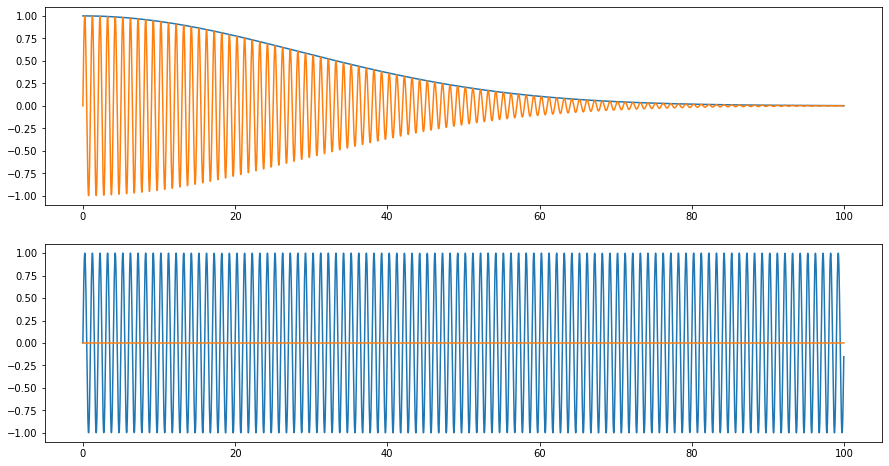

In [32]:
_, (ax, ax2) = plt.subplots(nrows=2, figsize=(15,8))

win = time_domain.gauss_window(np.ones(t.shape)*1, freq, t, b)

ax.plot(t, win)
ax.plot(t, d1_win)

ax2.plot(t, d1_win/win)
ax2.plot(t, d1_win/win - d1)